# Pacific oyster larval dispersal modelling
### Master script with annotations
##### Last edited - 28/01/2022

This script runs a simple version of the models I use to generate larval dispersal trajectories. It runs a model for the year 2000, using only 10 particles. I have commented on the code throughout and exlain what each section is doing, and I have also included plots that illustrate some of the processes taking place. 

#### Contents of script:

*Setting up and running the simulation*
1. [Import the required modules to run the simulation](#section1)
2. [Construct the `FieldSet` object](#section2)
3. [Create a `landmask` that identifies land and ocean cells and add it to the `FieldSet`](#section3)
5. [Create an `unbeaching field` that repels particles from land](#section4)
6. [Add a uniform diffusivity value to the `FieldSet`](#section6)
7. [Define the custom kernels to be used in the simulation](#section7)
8. [Create a custom `ParticleClass` that writes all of the desired information to the output file](#section8)
9. [Load the spawning locations file and create the `ParticleSet`](#section9)
10. [Cast the custom kernels created above into kernel objects](#section10)
11. [Run the simulation](#section11)
*Checking and viewing the output*

12. [Plot a very basic trajectories map](#section12)
13. [Plot the output as a .gif](#section13)
14. [View a histogram of the number of particle observations per bin](#section14)
15. [Check that the unbeaching kernel has worked properly](#section15)
13. [Open the `netCDF` output file and view the output with `xarray`](#section16)

---
<a id='section1'></a>

Before the script can be run you need to import the required modules and functions. These include functions from the dedicated parcels module, as well as more general modules and functions. These are all loaded in the overall `py3_parcels` environment. The modules below are those that are required to run the model.

In [57]:
# Import the necessary modules to run the script
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ParcelsRandom, Variable, VectorField, DiffusionUniformKh
from datetime import timedelta as delta
import numpy as np
from datetime import datetime
import pandas as pd
import itertools
import random
import math
import xarray as xr
from scipy import interpolate
import numpy.ma as ma
from operator import attrgetter

These modules are used to generate the figures throughout this script - They are not required for the simulation.

In [58]:
# Import the necessary modules to generate the figures
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from IPython.display import Image
from copy import copy

---
<a id='section2'></a>

The first step to any Parcels simulation is creating the `FieldSet`, which defines the field upon which your particles will be advected. This involves 5 defining steps:

1. Specifying the paths to the files containing the data 
2. Specifying, for both the `U` and `V` fields, where to find the data for each dimension in each file 
3. Specifying the names of the variables within the files
4. Specifying the names of the dimensions of each variable within the files
5. Casting the data into a `fieldset` object using the `from_nemo` method - as I am using hydrodynamic data from NEMO

This results in the `fieldset` object, which contains all of the data for the hydrdynamic fields used in the model.

In [59]:
# 1.
ufiles = '2000_shelftmb_grid_U.nc' # the name of the file containing the zonal velocity
vfiles = '2000_shelftmb_grid_V.nc' # the name of the file containing the meridional velocity
mesh_mask = 'coordinates.nc' # the name of the file containing the grid specifications for the hydrodynamic data       

# 2.
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': ufiles, 'data': ufiles}, # get coordinate data from the grid specification file, and everything else from the zonal velocity file
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': ufiles, 'data': vfiles}} # get coordinate data form the grid specification file, make sure depth matches the data for zonal velocity, and get the actual values from the meridional velocity file

# 3.
variables = {'U': 'vozocrtx', # the name of the zonal velocity within the file '2000_shelftmb_grid_U'
             'V': 'vomecrty'} # the name of the meridional velocity within the file '2000_shelftmb_grid_V'

# 4.
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthu', 'time': 'time_counter'}, # the names of lon and lat in the 'coordinates' file, and the names of depth and time within the '2000_shelftmb_grid_U' file
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthu', 'time': 'time_counter'}} # the names of lon and lat in the 'coordinates' file, the name of depth within the '2000_shelftmb_grid_U' file, and the name of time within the '2000_shelftmb_grid_V' file

# 5.
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

---
<a id='section3'></a>

In the following sections of code I add a `landmask` and unbeaching fields to the `fieldset`. The landmask is used in the creation of the unbeaching fields which prevent particles from becoming 'beached' (advecting onto land) prior to the end of the model in order to maximise output. 

To create the landmask you need to load the files containing the zonal and meridional velocities outside of the `fieldset object`. Here I save them as `ufields` and `vfields` respectively. I then create a landmask by using the `U` and `V` fields to create a masked array, in which cells of the hydrodynamic model that do not contain a velocity value (and are therefore land) are masked (labelled as `False`). This is then converted to integers, assigning a value of `1` to cells labelled as `True`, and `0` to cells labelled as `False`. The landmask is then added to the `fieldset` using `add_field`, making sure to specify that the `lon` and `lat` values are the same as those in the `fieldset`, and specifying that the mesh is spherical so that it matches the format of the hydrodynamic data.

In [60]:
# Open the files containing the U and V velocities
ufields = xr.open_dataset('2000_shelftmb_grid_U.nc')
vfields = xr.open_dataset('2000_shelftmb_grid_V.nc')

landmask = np.logical_or(np.ma.masked_equal(ufields['vozocrtx'][0,0],0.).mask, # Creates a masked array
                         np.ma.masked_equal(vfields['vomecrty'][0,0],0.).mask)

landmask = landmask.astype('int') # Convert to integers

fieldset.add_field(Field('landmask', landmask, lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical')) # Add to fieldset

At this point I can print the `landmask` just to check that it is correct, which gives me an array of 1s and 0s as expected.

In [61]:
print(landmask)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


I can also plot a small section of the hydrodynamic field and colour it by the `landmask` to check that all seems correct.

In [62]:
coords = xr.open_dataset(mesh_mask, decode_times=False)

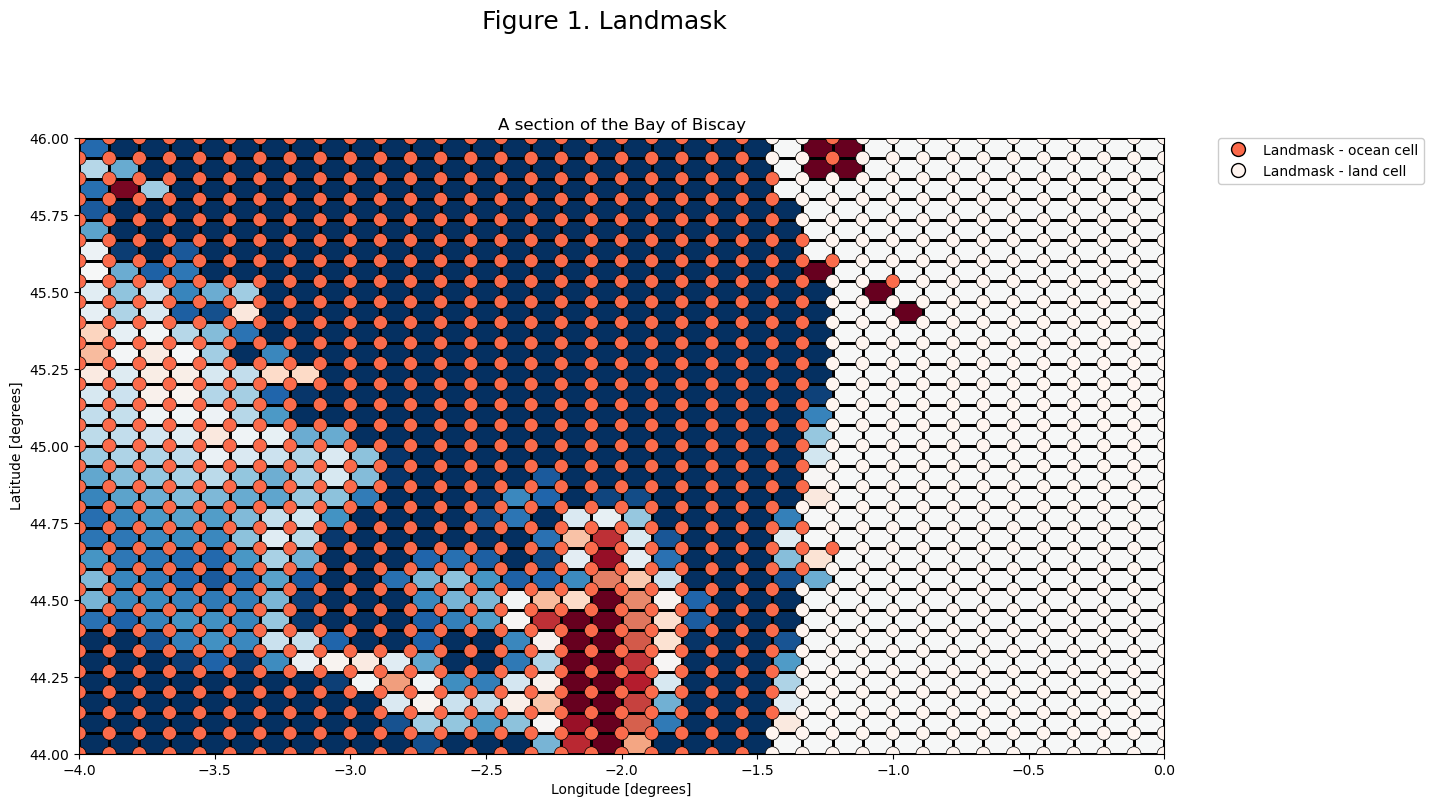

In [63]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.04)
ax=plt.axes()

ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_title('A section of the Bay of Biscay')
ax.set_xlim(-4, 0)
ax.set_ylim(44, 46)

ax.pcolormesh(coords['glamf'][0], coords['gphif'][0], vfields['vomecrty'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k', linewidth=1)
ax.scatter(coords['glamf'][0], coords['gphif'][0], c=landmask, cmap='Reds_r', s=100, edgecolors='k', vmin=-1, linewidth=0.5)

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c=color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c=color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Landmask - ocean cell', 'Landmask - land cell'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., framealpha=1)
plt.show()

Finally, I create the unbeaching field that prevents particles from advecting or diffusing onto land. I first isolate the `lon` and `lat` values from the fieldset and combine them into a mesh grid which will be used in the function that generates the unbeaching field.

In [64]:
lons = fieldset.U.lon
lats = fieldset.U.lat

fieldmesh_x, fieldmesh_y = np.meshgrid(lons, lats)

The unbeaching function calculates the closest ocean cell to each land cell and creates a small vector field that moves particles that end up on land back to the nearest ocean cell. To do this it first finds the indices of the landmask that correspond to the ocean (0) and land (1). It then creates two empty arrays of the same shape as the longitudes and latitudes of the `fieldset`, one for the horizontal direction (x) and one for the vertical direction (y). Then, for each land cell it finds the lon and lat, and then calcultes the distance to the ocean cells in terms of lon and lat (degrees). This is then combined to create an array of the distances to all ocean cells, and the minimum distance is calculated to find the ocean cell(s) that is/are closest to the land cell in question. The indices of the minimum distance(s) in the array of all distances is then calculated. If there is only one ocean cell that is closest to the land cell then the lon and lat of this ocean cell is calculated and a vector field is created that moves the beached particle towards that location. If there is more than one ocean cell that are equally close to the land cell, it calculates the mean of the lons and lats of the ocean cells and again creates a vector field that moves the beached particle towards that location. The function then returns the two overall vector fields for all the land cells - one in the horizontal direction (`vectorfield_x`) and one in the vertical direction (`vectorfield_y`).

In [65]:
def Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y): # The function requires the input of a landmask and two mesh grids containing the horizontal and vertical information
    
    # Find indices of land and ocean
    oceancells = np.where(landmask == 0)
    landcells = np.where(landmask == 1)
        
    # Create empty arrays
    vectorfield_x = np.zeros(fieldmesh_x.shape)
    vectorfield_y = np.zeros(fieldmesh_y.shape)
        
    # Repeat the loop for all the land cells
    for i1 in range (len(landcells[1])):
        # Find the lon and lat for all of the land cells
        lon_coast = fieldmesh_x[landcells[0][i1], landcells[1][i1]]
        lat_coast = fieldmesh_y[landcells[0][i1], landcells[1][i1]]
            
        # Calculate the distance from each land cell to the ocean cells
        dist_lon = (lon_coast - fieldmesh_x[oceancells[0], oceancells[1]])
        dist_lat = (lat_coast - fieldmesh_y[oceancells[0], oceancells[1]])
        
        # Combine the values to get an array of the distances to ocean cells
        dist_to_ocean = np.sqrt(np.power(dist_lon, 2) + np.power(dist_lat, 2))
        # Calculate the minimum distance from each land cell to the ocean cells
        min_dist = np.min(dist_to_ocean)
        # Find the indices of the minimum distances within the overall distance array
        i_min_dist = np.where(dist_to_ocean == min_dist)
        
        # If there is only one ocean cell that is closest...
        if len(i_min_dist[0]) == 1:
            # Find the lon and lat of the ocean cell
            lon_ocean = fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            lat_ocean = fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]]
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
        
        # If there are multiple ocean cells that are closest...
        elif len(i_min_dist[0]) > 1:
            # Take the mean of the lons and lats of all the cells
            lon_ocean = np.mean(fieldmesh_x[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            lat_ocean = np.mean(fieldmesh_y[oceancells[0][i_min_dist], oceancells[1][i_min_dist]])
            
            # Create a vector field 
            vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
            vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)    
    
    return vectorfield_x, vectorfield_y

I am then applying the unbeaching function to the `fieldset` to create two vectors specific to the hydrodynamic data I am using, converting them to `Field` objects, and then addaing them to the `fieldset` (again using the `add_field` method). The two individual field objects are then combined into a `VectorField` object, which stores the two fields that toegther define one vector field (and allows them to be used in kernels), and added to the `fieldset`.

In [66]:
landvector_U, landvector_V = Unbeaching_Field(landmask, fieldmesh_x, fieldmesh_y) # Apply the function

# Convert to Field objects
U_land = Field('U_land', landvector_U, lon=lons, lat=lats, fieldtype='U', mesh='spherical')
V_land = Field('V_land', landvector_V, lon=lons, lat=lats, fieldtype='V', mesh='spherical')

# Add to the fieldset
fieldset.add_field(U_land)
fieldset.add_field(V_land)

vectorfield_unbeaching = VectorField('UV_unbeach', U_land, V_land) # Combine and convert to vector field

fieldset.add_vector_field(vectorfield_unbeaching) # Add to the fieldset

C:\Users\au760477\AppData\Local\Temp\ipykernel_7760\3574750108.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vectorfield_x[landcells[0][i1], landcells[1][i1]] = (lon_ocean - lon_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
C:\Users\au760477\AppData\Local\Temp\ipykernel_7760\3574750108.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vectorfield_y[landcells[0][i1], landcells[1][i1]] = (lat_ocean - lat_coast) / np.sqrt((lon_ocean - lon_coast)**2 + (lat_ocean - lat_coast)**2)
C:\Users\au760477\AppData\Local\Temp\ipykernel_7760\3574750108.py:45: RuntimeWarning: invalid value encountered in scalar divide

I then define a custom kernel that uses the created fields to move particles that end up on land back to the ocean. If the particle is on land, as defined by the `landmask`, the unbeaching velocities are used to move it back to the ocean cells.

In [67]:
def Unbeaching(particle, fieldset, time):
    if particle.on_land == 1:  # If the particle is on land
        (u_land, v_land) = fieldset.UV_unbeach[time, particle.depth, particle.lat, particle.lon]  # the land U and V velocities are used
        particle.lon += u_land * particle.dt # particle lon becomes the u_land field at that timestep
        particle.lat += v_land * particle.dt # particle lat becomes the v_land field at that timestep
        particle.on_land = 0  # the particle is no longer on land

---
<a id='section6'></a>

The simulations I am running use a uniform diffusivity value as AMM7 does not provide horizontal diffusivity values. I have chosen a diffusivity value of 1 m^2/s because the resolution of the hydrodynamic data is very high so a large diffusivity value is not necessary. 
>*Note, in order for Parcels to automatically convert the units of the zonal and meridional diffusivities, they MUST be named `Kh_zonal` and `Kh_meridional`.*

To add the diffusivity values to the `fieldset`, I create an object called `size2D` that stores the dimensions of the zonal velocity from the `fieldset`, and then when adding diffusivity to the `fieldset` I create an array of ones in the shape of these dimensions, which is then multiplied by the `Kh_zonal` and `Kh_meridional` values to ensure that the diffusivity is constant over the hydrodynamic field, and is also the correct shape. A constant value of `dres` is also added to the `fieldset` at this point. This is what the Parcels documentation has to say about `dres`: 

> "To make a central difference approximation for computing the gradient in diffusivity, a resolution for this approximation dres is needed: Parcels approximates the gradients in diffusivities by using their values at the particle's location ± dres (in both x and y). Currently, it is unclear what the best value of dres is. From experience, its size of dres should be smaller than the spatial resolution of the data, but within reasonable limits of machine precision to avoid numerical errors."

In [68]:
kh_zonal = 100 
kh_meridional = 100 

size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim) # Store the dimensions of the zonal velocity from the FieldSet

fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))
fieldset.add_field(Field('Kh_meridional', kh_meridional*np.ones((size2D), dtype=np.float32), lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat, mesh='spherical'))

fieldset.add_constant('dres', 0.01)

---
<a id='section7'></a>

I then go on to define all of the custom kernels that are used in my simulations. These are as follows:

1. A kernel that keeps track of the age of the particle, which is then used in the `particle_death` kernel (`SampleAge`)
2. A kernel that samples whether a particle is over land using the `landmask`, which is used to determine whether the unbeaching field needs to be applied to a particle or not (`Sample_land`)
3. A kernel that ensures that particles are deleted following 28 days, which is the maximum length of the PLD (`Particle_death`)
4. A kernel that simply deletes a particle (used as a solution to error messages) (`DeleteParticle`)
5. A kernel that calculates the distance travelled by a perticle (explained in more detail below) (`Distance`)

In [69]:
def SampleAge(particle, fieldset, time):
    particle.age += particle.dt 

def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]
    
def Particle_death(particle, fieldset, time):
    runtime = 2419200 # 28 days (in seconds)
    if particle.age > runtime:
        particle.delete()
        
def DeleteParticle(particle, fieldset, time):
    particle.delete()

The `Distance` kernel calculates the Euclidean distance travelled by a particle in the latitudinal (using 111 (1.11e2) km per degree of latitude), and the longitudinal direction (multiplying by cosine(lat) because the mesh is spherical). 

In [70]:
def Distance(particle, fieldset, time):
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2 # latitudinal distance
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi/180) # longitudinal distance
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2)) # calculate Euclidean distance
    particle.prev_lon = particle.lon # Set the values for the next time step   
    particle.prev_lat = particle.lat

These kernels can only be executed once the `ParticleSet` has been created.

---
<a id='section8'></a>

The next step is to create a custom `ParticleClass` that will sample all of the variables designated in the custom sampling kernels written above. For these simulations these are:
1. Whether the particle is on land (`on_land`)
4. The age of the particle (`age`)
5. The cumulative distance travelled by a particle at each timestep (`distance`)
6. The longitude of the particle at the previous timestep (`prev_lon`)
7. The latitude of the particle at the previous timestep (`prev_lat`)

If `to_write` equals `False` then the data is not written to the output file. This is the case for the information that is not useful to post-processing of the simulation. 

In [71]:
class CustomParticle(JITParticle):
    on_land = Variable('on_land', to_write=False)
    age = Variable('age', dtype=np.float32, initial=0, to_write=False)
    distance = Variable('distance', dtype=np.float32, initial=0)
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False, initial=attrgetter('lon'))
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False, initial=attrgetter('lat'))

---
<a id='section9'></a>

I now create the `ParticleSet`, which defines my particles and the information needed to advect them on the `fieldset`. The locations from which I advect the particles were generated in R Studio and saved as a .csv file, which is read in here. The latitude and longitude of the spawning locations are read in and then repeated for the number of particles I am wanting to advect (`n`), which here is 10 as it is a simplified version of my actual simulations. 

I then specify the start and end dates of the spawning period, which were chosen based on the scientific literature, and convert them to ordinals. This means that I can generate a random spawning time between these two dates for each particle, and convert it back to a datetime object for the `pset`. The dates are accurate to the day, so each particle is released at midnight on the chosen random day, but this shouldn't be a problem as each particle is being released on a different day and for an extended period so the full tidal cycle will be captured. 

These parameters are all then cast into a `pset` object, using the custom `ParticleClass` defined above. Note, I do not specify the depth of the particles at this point because the simulations I am running are passive 2D models, and so advection is based on surface currents.

In [72]:
spawninglocs = pd.read_csv('Spawning_locations_2000_1_deg.csv') # Load the spawning csv file

lat = spawninglocs.lat.tolist()
lon = spawninglocs.lon.tolist()

n = 100 # Number of particles

lat = list(itertools.chain.from_iterable(itertools.repeat(x, n) for x in lat))
lon = list(itertools.chain.from_iterable(itertools.repeat(x, n) for x in lon))

start_time = datetime(2000, 7, 18).toordinal()
end_time = datetime(2000, 8, 16).toordinal()
random_ordinal = np.random.randint(start_time, end_time, size=len(lat)) # Generate random dates
random_start = [datetime.fromordinal(date) for date in random_ordinal] # Convert back to datetime

pset = ParticleSet(fieldset=fieldset, # The fieldset created at the start
                   pclass=CustomParticle, # The custom ParticleClass defined above
                   lon=lon, # longitude data
                   lat=lat, # latitude data
                   time=random_start) # list of random dates

---
<a id='section10'></a>

The custom kernels created earlier then have to be cast into kernel objects using `pset.Kernel` in order to work in the simulation. This is the point at which you find out if the kernels function as if they do not then an error message will be thrown. It is easiest to add all of the kernels together into one `kernel` object as this saves writing them all out in the following step.

In [73]:
# Cutom kernels need to be cast into a kernel object using pset.Kernel before they can function 
kernels = pset.Kernel(AdvectionRK4)+ pset.Kernel(Particle_death)+ pset.Kernel(SampleAge)+ pset.Kernel(Sample_land)+pset.Kernel(Unbeaching)+pset.Kernel(Distance)+pset.Kernel(DiffusionUniformKh)

---
<a id='section11'></a>

The final step is to run the model. To start I define the output file using `pset.ParticleFile`, which specifies the name of the output file and the timestep of the output (`outputdt`), which here I have specified as hourly because the hydrodynamic data I am using has an hourly resolution.

I then use `pset.execute` to run the simulation, which requires the following information:
1. Any kernels to be used in the simulation (here this is `kernels` which I created above)
2. the total length of the simulation (`runtime`) - here this is 43 days because that covers 28 days for the entire spawning period (i.e. particles that are released on the final day of the spawning period will still be able to advet in full)
3. the timestep of the kernels (`dt`), which determines how often the kernels are ran (here I have used a timestep of 5 minutes)
4. Any recovery kernels to be used during the simulations (more detail below)
5. The details of the output file

The recovery kernels provide a solution to common errors that will prevent the entire model from crashing. Here I have specified that if a particle goes out of the bounds of the model, or an interpolation error is thrown, the particle that has caused the error should be deleted. As in my actual models I am using such high numbers of particles (100,000), deleting the small amounts of particles that produce these errors will not affect the overall power of my results. 
>*Note, I attempted to determine the cause of the interpolation error by asking the develpers on the Parcels GitHub, but they were unsure what was causing it so I deemed the best solution to be to just delete the particles as it is a very small number of particles that are affected.*

Finally the output file is closed so that it can be saved in full using `output_file.close()`

In [74]:
# Specify name of output file and time step (update frequency) of the output
output_file = pset.ParticleFile(name="2000_5sects_output.zarr", 
                                outputdt=delta(days=1))

# Execute the particle set
pset.execute(kernels,                                               # The kernels defined and then cast above
             runtime=delta(days=43),                            # Total length of the simulation (incl. competency)
             dt=delta(seconds=5),                                   # The time step of the kernels
             output_file = output_file)                             # save output to file defined above

INFO: Output files are stored in 2000_5sects_output.zarr.
100%|████████████████████████████████████████████████████████████████| 3715200.0/3715200.0 [3:52:21<00:00, 266.49it/s]


---
<a id='section12'></a>

Parcels has a basic function for plotting the trajectories of particles, which can be useful for looking at outputs at a glance, or just to check that the simulation has ran as expected. This is done using the `plotTrajectoriesFile` function as below.

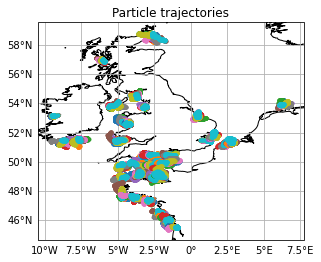

<module 'matplotlib.pyplot' from 'C:\\Users\\cclubley\\Miniconda3\\envs\\py3_parcels\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [22]:
from parcels import plotTrajectoriesFile

plotTrajectoriesFile("2000_Random_10_10_4_14_passive_2D_1deg_output.nc")

You can also plot the trajectories as an animation.
<a id='section13'></a>

In [23]:
plotTrajectoriesFile('2000_Random_10_10_4_14_passive_2D_1deg_output.nc', mode='movie2d_notebook')

C:\Users\cclubley\Miniconda3\envs\py3_parcels\lib\site-packages\parcels\scripts\plottrajectoriesfile.py:92: RuntimeWarning: invalid value encountered in remainder
  ax.set_xlim(np.nanmin((lon+central_longitude+180) % 360 - 180), np.nanmax((lon+central_longitude+180) % 360 - 180))


Or view a histogram of the number of particle observations per bin.
<a id='section14'></a>

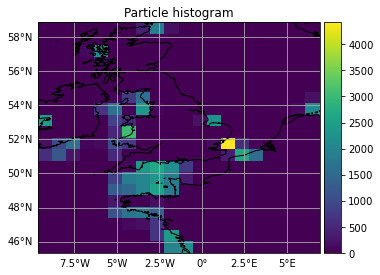

In [24]:
plotTrajectoriesFile('2000_Random_10_10_4_14_passive_2D_1deg_output.nc', mode='hist2d');

You can also create a plot to show how the unbeaching kernel works to move particles away from the coast and back to the ocean.
<a id='section15'></a>

In [27]:
output = xr.open_dataset('2000_Random_10_10_4_14_passive_2D_1deg_output.nc')

In [28]:
particle = output['distance']>=0

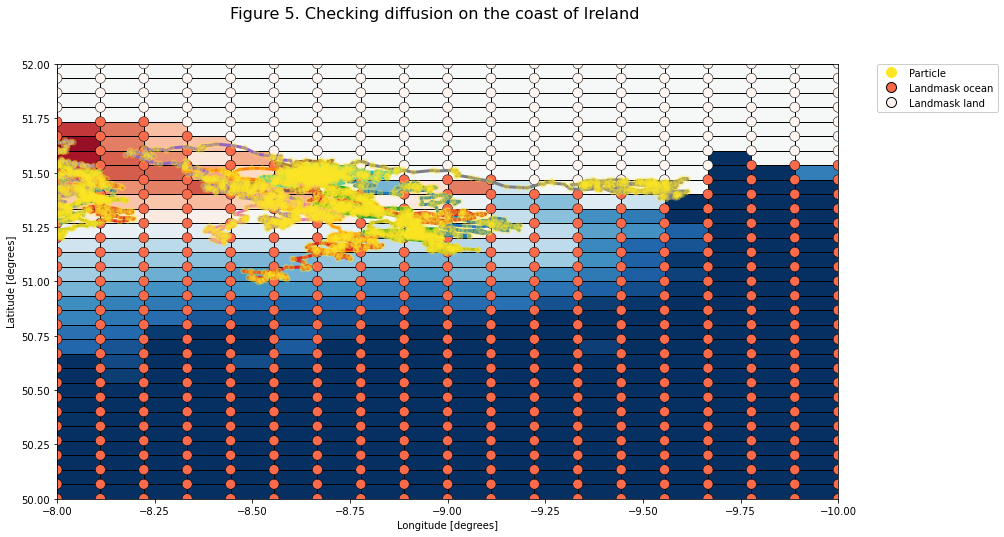

In [30]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Figure 5. Checking diffusion on the coast of Ireland', fontsize=16)
ax=plt.axes()

ax.set_ylabel('Latitude [degrees]')
ax.set_xlabel('Longitude [degrees]')
ax.set_xlim(-8, -10)
ax.set_ylim(50, 52)

ax.pcolormesh(coords['glamf'][0], coords['gphif'][0], vfields['vomecrty'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k', linewidth=1)
ax.plot(output['lon'].T, output['lat'].T, linewidth=3, zorder=1)
ax.scatter(output['lon'], output['lat'], c=particle, s=30, cmap='viridis_r', alpha=0.3, zorder=2)
ax.scatter(coords['glamf'][0], coords['gphif'][0], c=landmask, cmap='Reds_r', s=100, edgecolors='k', vmin=-1, linewidth=0.5)

color_particle = copy(plt.get_cmap('viridis'))(256)
color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c=color_particle, marker='o', markersize=10, lw=0),
                Line2D([0], [0], c=color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c=color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax.legend(custom_lines, ['Particle', 'Landmask ocean', 'Landmask land'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., framealpha=1)
plt.show()

---
<a id='section13'></a>

It can also be useful to look at the full output. Using xarray I can open the output netCDF file and view it in netCDF format, which tells me the dimensions of each variable and the size of the variables themselves. <a id='section16'></a>

In [31]:
output # View

<xarray.Dataset>
Dimensions:     (traj: 340, obs: 244)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 58.81 58.82 58.82 58.84 ... 45.58 nan nan
    lon         (traj, obs) float64 -2.647 -2.668 -2.706 ... -0.9598 nan nan
    z           (traj, obs) float64 ...
    settle      (traj, obs) float32 ...
    distance    (traj, obs) float32 0.0 4.097 8.26 13.39 ... 903.5 903.7 nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

---
<a id='section14'></a>